# Next Word Prediction with LSTM

Build a model to predict the next word of your text using Long Short Term Memory (LSTM)

Dataset for training: https://www.gutenberg.org/files/1342/1342-0.txt

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import os
import re
import shutil
import glob
import string
import pickle

import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelBinarizer, LabelEncoder

In [3]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Sat Oct  2 07:05:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    29W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data path

In [4]:
DATA_PATH = '/content'
DATA_DIR  = os.path.join(DATA_PATH, 'sample_data')
DATA_DIR

'/content/sample_data'

In [5]:
if not os.path.exists(DATA_DIR):
  os.mkdir(DATA_DIR)

In [ ]:
os.listdir(DATA_DIR)

In [7]:
filepaths = glob.glob(os.path.join(DATA_DIR, '*.txt'))
print(len(filepaths))
filepaths[:3]

1


['/content/sample_data/pride_and_prejudice.txt']

# Read data

In [8]:
content = ''
for x in filepaths:
  xcontent = open(x, 'r').read().lower()
  content = content + xcontent + ' '

content[:1000]

'\ufeffthe project gutenberg ebook of pride and prejudice, by jane austen\n\nthis ebook is for the use of anyone anywhere in the united states and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever. you may copy it, give it away or re-use it under the terms\nof the project gutenberg license included with this ebook or online at\nwww.gutenberg.org. if you are not located in the united states, you\nwill have to check the laws of the country where you are located before\nusing this ebook.\n\ntitle: pride and prejudice\n\nauthor: jane austen\n\nrelease date: june, 1998 [ebook #1342]\n[most recently updated: august 23, 2021]\n\nlanguage: english\n\ncharacter set encoding: utf-8\n\nproduced by: anonymous volunteers and david widger\n\n*** start of the project gutenberg ebook pride and prejudice ***\n\n\n\n\nthere is an illustrated edition of this title which may viewed at ebook\n[# 42671 ]\n\ncover\n\n\n\n\npride and prejudice\n\nby jane austen\n\ncontents\

Remove some unnecessary text

In [9]:
#replace unnecessary stuff with space
content = content.replace('\n', ' ')
content = content.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“','').replace('”','')  # new line, carriage return, unicode character --> replace by space
content = re.sub(r'[^\w\s]', '', content)
content = content.replace("_", ' ')

#remove unnecessary spaces 
content = content.split()
content = ' '.join(content)
content[:1000]

'the project gutenberg ebook of pride and prejudice by jane austen this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it away or reuse it under the terms of the project gutenberg license included with this ebook or online at wwwgutenbergorg if you are not located in the united states you will have to check the laws of the country where you are located before using this ebook title pride and prejudice author jane austen release date june 1998 ebook 1342 most recently updated august 23 2021 language english character set encoding utf8 produced by anonymous volunteers and david widger start of the project gutenberg ebook pride and prejudice there is an illustrated edition of this title which may viewed at ebook 42671 cover pride and prejudice by jane austen contents chapter 1 chapter 2 chapter 3 chapter 4 chapter 5 chapter 6 chapter 7 chapter 8 chapter 9 chapter 10 c

In [10]:
len(content)

677481

In [11]:
content[:50]

'the project gutenberg ebook of pride and prejudice'

# Feature Engineering

In [12]:
# Words to integers
# E.g: the project gutenberg ebook of pride and prejudice
#  => [1, 2, 4, 5, 5, ....]
tokenizer = Tokenizer()
tokenizer.fit_on_texts([content])

# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([content])[0]
sequence_data[:15]

[1, 176, 482, 911, 3, 321, 4, 1165, 30, 72, 2500, 41, 911, 23, 21]

In [13]:
len(sequence_data)

124737

In [14]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7097

In [15]:
sequences = []

for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  124734


array([[   1,  176,  482,  911],
       [ 176,  482,  911,    3],
       [ 482,  911,    3,  321],
       [ 911,    3,  321,    4],
       [   3,  321,    4, 1165],
       [ 321,    4, 1165,   30],
       [   4, 1165,   30,   72],
       [1165,   30,   72, 2500],
       [  30,   72, 2500,   41],
       [  72, 2500,   41,  911]])

Feature X and label y

In [16]:
X = []
y = []

for i in sequences:
  X.append(i[0:3])
  y.append(i[3])
    
X = np.array(X)
y = np.array(y)

In [17]:
print(X.shape)
print(y.shape)

(124734, 3)
(124734,)


In [18]:
print("Data: ", X[:10])
print("Labels: ", y[:10])

Data:  [[   1  176  482]
 [ 176  482  911]
 [ 482  911    3]
 [ 911    3  321]
 [   3  321    4]
 [ 321    4 1165]
 [   4 1165   30]
 [1165   30   72]
 [  30   72 2500]
 [  72 2500   41]]
Labels:  [ 911    3  321    4 1165   30   72 2500   41  911]


In [19]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [20]:
y.shape

(124734, 7097)

In [22]:
# label_encoder = LabelBinarizer()
# label_encoder.fit(y)
# y_labels = label_encoder.transform(y)
# y_labels.shape

In [23]:
vocab_size

7097

# Model

In [24]:
# The learned embedding needs to know how many dimensions will be used to represent each word. 
# That is, the size of the embedding vector space. That is, the size of the embedding vector space.
# Common values are 50, 100, and 300. Consider testing smaller or larger values.
dimensions_to_represent_word = 256

model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=3))

# We will use a two LSTM hidden layers with 100 memory cells each. 
# More memory cells and a deeper network may achieve better results.
model.add(LSTM(dimensions_to_represent_word, return_sequences=True))
model.add(LSTM(dimensions_to_represent_word))
model.add(Dense(dimensions_to_represent_word, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 10)             70970     
_________________________________________________________________
lstm (LSTM)                  (None, 3, 256)            273408    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 7097)              1823929   
Total params: 2,759,411
Trainable params: 2,759,411
Non-trainable params: 0
_________________________________________________________________


In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("next_words.h5", monitor='loss', verbose=1, save_best_only=True)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.1, batch_size=64, epochs=200, callbacks=[checkpoint], shuffle=True)

Epoch 1/200
1755/1755 [==============================] - 33s 17ms/step - loss: 2.4897 - accuracy: 0.7208 - val_loss: 16.2125 - val_accuracy: 0.0816

Epoch 00001: loss improved from inf to 2.48974, saving model to next_words.h5
Epoch 2/200
1755/1755 [==============================] - 27s 16ms/step - loss: 2.1981 - accuracy: 0.7275 - val_loss: 15.1076 - val_accuracy: 0.0885

Epoch 00002: loss improved from 2.48974 to 2.19815, saving model to next_words.h5
Epoch 3/200
1755/1755 [==============================] - 27s 16ms/step - loss: 2.0394 - accuracy: 0.7352 - val_loss: 14.4573 - val_accuracy: 0.0940

Epoch 00003: loss improved from 2.19815 to 2.03939, saving model to next_words.h5
Epoch 4/200
1755/1755 [==============================] - 27s 16ms/step - loss: 1.9209 - accuracy: 0.7401 - val_loss: 13.9094 - val_accuracy: 0.0979

Epoch 00004: loss improved from 2.03939 to 1.92090, saving model to next_words.h5
Epoch 5/200
1755/1755 [==============================] - 27s 15ms/step - loss: 1

In [27]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


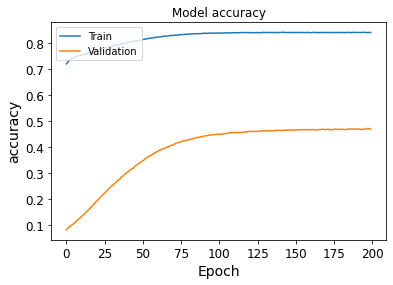

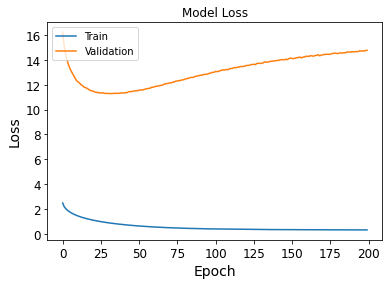

In [28]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Not great! Need to improve in future.

# Save and load the model

In [59]:
# tokenizer.word_index.items()
# dict_items([('the', 1), ('to', 2), ('of', 3), ('and', 4)...])

In [68]:
from tensorflow.keras.models import load_model

# Load the model and tokenizer
model = load_model('next_words.h5')
tokenizer = pickle.load(open('token.pkl', 'rb'))

def Predict_Next_Words(model, tokenizer, text):

  sequence = tokenizer.texts_to_sequences([text])
  sequence = np.array(sequence)
  preds = np.argsort(model.predict(sequence))[0][::-1][:5]
  # preds = np.argmax(model.predict(sequence))
  
  predicted_words = []
  for key, value in tokenizer.word_index.items():
      if value in preds:
          predicted_words.append(key)

  return predicted_words

# Prediction

In [69]:
text = "He was quite"

if text == "0":
  print("Execution completed.....")

else:
  try:
    text = text.split(" ")
    text = text[-3:]
    print(text)

    pred_words = Predict_Next_Words(model, tokenizer, text)
    print('Predicted words: ', pred_words)
      
  except Exception as e:
    print("Error occurred: ",e)

['He', 'was', 'quite']
Predicted words:  ['a', 'so', 'young', 'happy', 'short']


In [72]:
texts = ["She was quite",
         "thank you for",
         "She is pretty",
         "He loves you",
         "there were six",
         "I was so",
         "Any house would"
         ]

for text in texts:
  if text == "0":
    print("Execution completed.....")
    break

  else:
    try:
      text = text.strip().split(" ")
      text = text[-3:]
      print('Input text: ', text)

      pred_words = Predict_Next_Words(model, tokenizer, text)
      print('Predicted words: ', pred_words)
      print()
        
    except Exception as e:
      print("Error occurred: ",e)
      continue

Input text:  ['She', 'was', 'quite']
Predicted words:  ['glad', 'disappointed', 'decided', 'amazed', 'unprepared']

Input text:  ['thank', 'you', 'for']
Predicted words:  ['you', 'him', 'my', 'me', 'explaining']

Input text:  ['She', 'is', 'pretty']
Predicted words:  ['by', 'able', 'amiable', 'assured', 'fond']

Input text:  ['He', 'loves', 'you']
Predicted words:  ['have', 'are', 'must', 'did', 'know']

Input text:  ['there', 'were', 'six']
Predicted words:  ['of', 'much', 'one', 'other', 'great']

Input text:  ['I', 'was', 'so']
Predicted words:  ['sure', 'afraid', 'bad', 'vexed', 'frightened']

Input text:  ['Any', 'house', 'would']
Predicted words:  ['in', 'you', 'be', 'been', 'subsided']



# Save the model

In [73]:
# serialize model to JSON
model_json = model.to_json()
with open("Next_Word_Pred_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Next_Word_Pred_model_weight.h5")
print("Saved model to disk")

Saved model to disk


In [74]:
# save the network to disk
print("Save the model...")
model.save("Next_Word_Pred_model.model", save_format="h5")

Save the model...


In [34]:
# # later...
 
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
 
# # evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [75]:
from google.colab import files
files.download("Next_Word_Pred_model_classweight.json")
files.download("Next_Word_Pred_model_classweight_weight.h5")
files.download("Next_Word_Pred_model_classweight.model")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>